In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from src.utils import get_project_root, load_pickle
from src.components.model_loader import get_models, ModelAndScalers
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import log_loss, precision_score, mean_absolute_error
from scipy.signal import savgol_filter


# Data Ingestion

In [282]:
project_directory = get_project_root()
data_directory = os.path.join(project_directory, 'Dataset\\')
print(data_directory)

C:\Users\Illia\Desktop\IMPRESS\Dataset\


In [283]:
offline_df = pd.read_csv(os.path.join(data_directory, "20220311_114449_impress_backup_offlinemessungen.csv"), sep=';')

online_df = pd.read_csv(os.path.join(data_directory, "20220311_114449_impress_backup_sensors.csv"), sep=';')
pd.set_option('display.max_columns', 16)
print(online_df.dtypes)
offline_df.head()

experimentnummer    float64
timestamp           float64
waschen               int64
spuelen             float64
csbeq               float64
truebung            float64
druck1              float64
druck2              float64
druck3              float64
fluss1              float64
fluss2              float64
ph                  float64
leitfaehigkeit      float64
alkalinitaet        float64
vorschlagsnummer    float64
bsbeq               float64
abs254              float64
abs360              float64
abs210              float64
reserv1             float64
reserv2             float64
dtype: object


aktivsauerstoff  anionischetenside  bsb  carbonathaerte     csb  \
0             20.0              27.30  0.0            21.5  2426.0   
1             20.0              27.30  0.0            21.5  2426.0   
2             20.0              27.30  0.0            21.5  2426.0   
3             10.0               1.88  0.0             6.8    29.5   
4             50.0             260.00  0.0            21.9  3792.0   

   leitfaehigkeit  nichtionischentenside  oberflaechenspannung  ...     ph  \
0          1105.0                  215.0                 39.90  ...  7.360   
1          1105.0                  215.0                 39.90  ...  7.360   
2          1105.0                  215.0                 39.90  ...  7.360   
3            30.0                   12.0                 61.55  ...  8.070   
4          1100.0                  660.0                 31.85  ...  6.385   

   truebung  wasserstoffperoxid  bemerkungen timestamp_probeentnahme  \
0     32.90                1.55           W1              1615803865   
1     32.90                1.55           W1              1615803865   
2     32.90                1.55           W1              1615803865   
3      1.90                0.00           S1              1615814270   
4     74.65               73.35           W1              1615545009   

   timestamp_messung  vorschlagnummer  experimentnummer  
0         1615804010              -12                12  
1         1615804010              -12                12  
2         1615804010              -12                12  
3         1615814315              -12                12  
4         1615544976              -11                11  

[5 rows x 17 columns]

In [284]:
online_df = online_df[online_df['vorschlagsnummer'] >= 0]
online_df.head()

experimentnummer     timestamp  waschen  spuelen      csbeq  truebung  \
4               1.0  1.624966e+09        0      1.0  45.758366  7.649211   
5               1.0  1.624966e+09        0      1.0  45.711973  7.676346   
6               1.0  1.624966e+09        0      1.0  45.801190  7.839979   
7               1.0  1.624966e+09        0      1.0  45.758366  7.852313   
8               1.0  1.624966e+09        0      1.0  45.715542  7.893427   

     druck1    druck2  ...  alkalinitaet  vorschlagsnummer      bsbeq  \
4  0.141451  0.165737  ...     -1.569999               3.0  30.181111   
5  0.140628  0.165041  ...     -1.532478               3.0  30.188248   
6  0.141379  0.164814  ...     -1.538865               3.0  30.125796   
7  0.140800  0.165357  ...     -1.579538               3.0  30.156130   
8  0.139941  0.164000  ...     -1.586798               3.0  30.070482   

     abs254    abs360    abs210  reserv1  reserv2  
4  0.056924  0.023622  0.211094     -0.0     -0.0  
5  0.057023  0.023672  0.211040     -0.0     -0.0  
6  0.056927  0.023640  0.210966     -0.0     -0.0  
7  0.056945  0.023703  0.211094     -0.0     -0.0  
8  0.056953  0.023500  0.211022     -0.0     -0.0  

[5 rows x 21 columns]

# EDA and Feature Extraction

In [285]:
offline_df.drop_duplicates(inplace=True)
online_df.drop_duplicates(inplace=True)

In [286]:
offline_df['experimentnummer'].unique()

array([12, 11, 10,  9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,  1,  2,  3,
        4,  5,  6,  7,  8, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 50, 51,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 52, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)

In [287]:
online_df['experimentnummer'].unique()

array([ 1.,  4.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 50., 51., 52., 53., 54., 55., 56., 57.,
       58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.,
       71., 72., 73., 74., 75., 76., 77., 78., 79., 80.])

In [288]:
np.setdiff1d(offline_df['experimentnummer'].unique(), online_df['experimentnummer'].unique())


array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

In [289]:
print(len(online_df), len(offline_df))

188770 171


In [290]:
online_df['waschen'].unique()

array([0, 1], dtype=int64)

In [291]:
print(len(online_df[online_df['waschen'] == 0]), len(online_df[online_df['waschen'] == 1]))

93441 95329


In [292]:
x=0
for i in range(1, 81):
    a = len(offline_df[offline_df['experimentnummer'] == i])
    print(a)
    x+=a
print(x)

5
4
4
4
4
4
4
4
6
6
4
4
4
4
4
5
7
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
171


In [293]:
offline_df[offline_df['experimentnummer'] == 19]

aktivsauerstoff  anionischetenside  bsb  carbonathaerte     csb  \
25             30.0              61.25 -1.0            39.6  2352.0   
26             10.0              19.05 -1.0            12.3   536.5   

    leitfaehigkeit  nichtionischentenside  oberflaechenspannung  ...     ph  \
25          1540.0                  260.0                 38.30  ...  7.080   
26           515.0                  110.0                 47.05  ...  7.555   

    truebung  wasserstoffperoxid  bemerkungen timestamp_probeentnahme  \
25     18.05               27.45           W1              1618480944   
26      7.45                9.10           S1              1618487664   

    timestamp_messung  vorschlagnummer  experimentnummer  
25         1618480740              -19                19  
26         1618487580              -19                19  

[2 rows x 17 columns]

In [294]:
offline_df[(offline_df['experimentnummer'] == 17) & (offline_df['bemerkungen'] == 'W1')]

aktivsauerstoff  anionischetenside  bsb  carbonathaerte     csb  \
18              40.0             251.00 -1.0            21.9  3052.0   
20              40.0             251.00 -1.0            21.9  3052.0   
21              10.0              44.40 -1.0             9.0    46.5   
102             -1.0               1.84 -1.0            -1.0    -1.0   

     leitfaehigkeit  nichtionischentenside  oberflaechenspannung  ...     ph  \
18           1049.5                  620.0                 34.10  ...  7.205   
20           1049.5                  620.0                 34.10  ...  7.205   
21            550.0                   95.0                 47.80  ...  7.465   
102            -1.0                  620.0                 36.95  ... -1.000   

     truebung  wasserstoffperoxid  bemerkungen timestamp_probeentnahme  \
18      38.45               32.70           W1              1618231882   
20      38.45               32.70           W1              1618220722   
21       4.70                7.25           W1              1618220722   
102     -1.00               -1.00           W1              1627288200   

     timestamp_messung  vorschlagnummer  experimentnummer  
18          1618231882              -17                17  
20          1618220700              -17                17  
21          1618220700              -17                17  
102         1627300800              132                17  

[4 rows x 17 columns]

In [295]:
offline_df[offline_df['ph']>=0]

aktivsauerstoff  anionischetenside  bsb  carbonathaerte     csb  \
0               20.0             27.300  0.0           21.50  2426.0   
3               10.0              1.880  0.0            6.80    29.5   
4               50.0            260.000  0.0           21.90  3792.0   
5               10.0              2.715  0.0            6.95    36.5   
6                0.0              0.000  0.0            4.65   997.0   
..               ...                ...  ...             ...     ...   
162             -1.0              0.350 -1.0           17.00   421.5   
165             -1.0             96.000 -1.0           46.00  2948.0   
166             -1.0              0.710 -1.0            8.00    20.0   
171             -1.0             95.000 -1.0            4.45  1705.0   
172             -1.0              8.600 -1.0            5.20   149.5   

     leitfaehigkeit  nichtionischentenside  oberflaechenspannung  ...     ph  \
0           1105.00                  215.0                 39.90  ...  7.360   
3             30.00                   12.0                 61.55  ...  8.070   
4           1100.00                  660.0                 31.85  ...  6.385   
5            290.00                    4.6                 62.45  ...  8.465   
6            280.00                    0.0                 49.00  ...  7.915   
..              ...                    ...                   ...  ...    ...   
162          627.80                   70.0                 59.20  ...  8.400   
165         1395.00                  160.0                 43.80  ...  8.020   
166          247.60                    2.0                 70.60  ...  7.060   
171          493.75                  110.0                 48.70  ...  7.400   
172          249.10                   13.0                 68.70  ...  7.940   

     truebung  wasserstoffperoxid  bemerkungen timestamp_probeentnahme  \
0       32.90                1.55           W1              1615803865   
3        1.90                0.00           S1              1615814270   
4       74.65               73.35           W1              1615545009   
5        2.10                0.00           S1              1615558576   
6        7.90                0.00           W1              1615286670   
..        ...                 ...          ...                     ...   
162      1.10               -1.00           S1              1641856323   
165     23.75               -1.00           W1              1642374604   
166      1.65               -1.00           S1              1642374708   
171     19.40               -1.00           W1              1643152266   
172      3.20               -1.00           S1              1643152311   

     timestamp_messung  vorschlagnummer  experimentnummer  
0           1615804010              -12                12  
3           1615814315              -12                12  
4           1615544976              -11                11  
5           1615558552              -11                11  
6           1615285850              -10                10  
..                 ...              ...               ...  
162         1641856424              300                75  
165         1642374794              312                77  
166         1642374836              312                77  
171         1643152377              330                80  
172         1643152413              330                80  

[117 rows x 17 columns]

In [296]:
offline_df[offline_df['vorschlagnummer']>0]

aktivsauerstoff  anionischetenside  bsb  carbonathaerte     csb  \
73              -1.0               0.00 -1.0           43.40  2346.0   
74              -1.0               0.00 -1.0           11.00   336.0   
75              -1.0               0.00 -1.0           30.20    -1.0   
76              -1.0             744.00 -1.0           35.60  8892.0   
77              -1.0               3.20 -1.0            6.70    48.5   
..               ...                ...  ...             ...     ...   
168             -1.0              -1.00 -1.0            9.00    -1.0   
169             -1.0               0.46 -1.0           32.00    -1.0   
170             -1.0              -1.00 -1.0            5.60    -1.0   
171             -1.0              95.00 -1.0            4.45  1705.0   
172             -1.0               8.60 -1.0            5.20   149.5   

     leitfaehigkeit  nichtionischentenside  oberflaechenspannung  ...     ph  \
73          1700.00                 140.00                 45.95  ...  7.530   
74           470.00                  45.00                 58.30  ...  8.080   
75          1265.00                 180.00                 44.20  ...  6.910   
76          1745.00                 880.00                 32.95  ...  7.920   
77           465.00                   5.85                 67.15  ...  7.645   
..              ...                    ...                   ...  ...    ...   
168           -1.00                   5.45                 69.90  ... -1.000   
169           -1.00                 150.00                 55.10  ... -1.000   
170           -1.00                   2.65                 70.90  ... -1.000   
171          493.75                 110.00                 48.70  ...  7.400   
172          249.10                  13.00                 68.70  ...  7.940   

     truebung  wasserstoffperoxid  bemerkungen timestamp_probeentnahme  \
73      22.45                -1.0           W1              1624959961   
74       7.60                -1.0           S1              1624965721   
75      42.60                -1.0           W1              1625043502   
76      46.55                -1.0           W1              1625478600   
77       0.80                -1.0           S1              1625487000   
..        ...                 ...          ...                     ...   
168     -1.00                 1.0           S1              1642547650   
169     -1.00                -1.0           W1              1642979491   
170     -1.00                -1.0           S1              1642979603   
171     19.40                -1.0           W1              1643152266   
172      3.20                -1.0           S1              1643152311   

     timestamp_messung  vorschlagnummer  experimentnummer  
73          1624960652                3                 1  
74          1624966472                3                 1  
75          1625044172                8                 2  
76          1625490000               21                 4  
77          1625490000               21                 4  
..                 ...              ...               ...  
168         1642547665              318                78  
169         1642979616              324                79  
170         1642979679              324                79  
171         1643152377              330                80  
172         1643152413              330                80  

[100 rows x 17 columns]

In [297]:
len(offline_df['experimentnummer'].unique())

63

In [298]:
offline_df.dtypes

aktivsauerstoff            float64
anionischetenside          float64
bsb                        float64
carbonathaerte             float64
csb                        float64
leitfaehigkeit             float64
nichtionischentenside      float64
oberflaechenspannung       float64
peressigsaeure             float64
ph                         float64
truebung                   float64
wasserstoffperoxid         float64
bemerkungen                 object
timestamp_probeentnahme      int64
timestamp_messung            int64
vorschlagnummer              int64
experimentnummer             int64
dtype: object

In [299]:
positive_parameters = [
    'bsb',
    'carbonathaerte',
    'csb',
    'leitfaehigkeit',
    'oberflaechenspannung',
    'peressigsaeure',
    'ph',
    'truebung',
    'wasserstoffperoxid',
]

# Dropping rows with negative values in the specified parameters
offline_positive = offline_df[(offline_df[positive_parameters] != -1).all(axis=1)].dropna()

In [300]:
offline_positive

aktivsauerstoff  anionischetenside    bsb  carbonathaerte     csb  \
0               20.0             27.300    0.0           21.50  2426.0   
3               10.0              1.880    0.0            6.80    29.5   
4               50.0            260.000    0.0           21.90  3792.0   
5               10.0              2.715    0.0            6.95    36.5   
6                0.0              0.000    0.0            4.65   997.0   
7                0.0              0.000    0.0            6.35   171.0   
8               20.0             50.500    0.0           38.40  2175.0   
9               10.0              1.090    0.0            6.90   119.0   
39              -1.0            146.000  860.0           10.35  4655.0   
40              -1.0             25.950  270.0            6.95   662.0   
109            200.0              0.000    0.0            0.00     0.0   

     leitfaehigkeit  nichtionischentenside  oberflaechenspannung  ...     ph  \
0            1105.0                  215.0                 39.90  ...  7.360   
3              30.0                   12.0                 61.55  ...  8.070   
4            1100.0                  660.0                 31.85  ...  6.385   
5             290.0                    4.6                 62.45  ...  8.465   
6             280.0                    0.0                 49.00  ...  7.915   
7             450.0                    0.0                 59.85  ...  7.755   
8            1525.0                  300.0                 36.85  ...  7.340   
9             475.0                    5.8                 64.45  ...  7.755   
39           1035.0                  240.0                 37.35  ...  5.200   
40            490.0                   65.0                 47.55  ...  6.340   
109             0.0                    0.0                 72.00  ...  7.600   

     truebung  wasserstoffperoxid  bemerkungen timestamp_probeentnahme  \
0       32.90                1.55           W1              1615803865   
3        1.90                0.00           S1              1615814270   
4       74.65               73.35           W1              1615545009   
5        2.10                0.00           S1              1615558576   
6        7.90                0.00           W1              1615286670   
7        5.75                0.00           S1              1615293147   
8        8.65               31.50           W1              1615209113   
9        0.70                0.00           S1              1615212995   
39     172.95               83.00           W1              1614341040   
40      65.00               12.25           S1              1614344400   
109    500.00              200.00         test              1634218204   

     timestamp_messung  vorschlagnummer  experimentnummer  
0           1615804010              -12                12  
3           1615814315              -12                12  
4           1615544976              -11                11  
5           1615558552              -11                11  
6           1615285850              -10                10  
7           1614688210              -10                10  
8           1615208786               -9                 9  
9           1615212662               -9                 9  
39          1614337500               -4                 4  
40          1614344040               -4                 4  
109         1634304608                1                 1  

[11 rows x 17 columns]

In [301]:
print(online_df)
positive_parameters = [
    'csbeq',
    'truebung',
    'druck1',
    'druck2',
    'druck3',
    'fluss1',
    'fluss2',
    'ph',
    'leitfaehigkeit',
    'alkalinitaet',
    'bsbeq',
    'abs254',
    'abs360',
    'abs210',
    'reserv1',
    'reserv2'
]

online_df = online_df[(online_df[positive_parameters] != -1).all(axis=1)].dropna()

        experimentnummer     timestamp  waschen  spuelen      csbeq  truebung  \
4                    1.0  1.624966e+09        0      1.0  45.758366  7.649211   
5                    1.0  1.624966e+09        0      1.0  45.711973  7.676346   
6                    1.0  1.624966e+09        0      1.0  45.801190  7.839979   
7                    1.0  1.624966e+09        0      1.0  45.758366  7.852313   
8                    1.0  1.624966e+09        0      1.0  45.715542  7.893427   
...                  ...           ...      ...      ...        ...       ...   
312146               1.0  1.646837e+09        0      1.0  30.486232  5.823761   
312147               1.0  1.646837e+09        0      1.0  30.580802  5.640394   
312148               1.0  1.646837e+09        0      1.0  30.614705  5.632993   
312149               1.0  1.646837e+09        0      1.0  30.459467  5.629704   
312150               1.0  1.646837e+09        0      1.0  30.587940  5.660951   

          druck1    druck2 

In [302]:
online_df[online_df.waschen == 1]

experimentnummer     timestamp  waschen  spuelen        csbeq  \
1804                 1.0  1.624961e+09        1      0.0   137.459008   
1816                 4.0  1.625479e+09        1      0.0  1365.384604   
1817                 4.0  1.625479e+09        1      0.0  1307.820949   
1818                 4.0  1.625480e+09        1      0.0  1373.100208   
1819                 4.0  1.625480e+09        1      0.0  1373.121620   
...                  ...           ...      ...      ...          ...   
310346               1.0  1.646831e+09        1      0.0    40.988835   
310347               1.0  1.646831e+09        1      0.0    40.940658   
310348               1.0  1.646831e+09        1      0.0    40.969207   
310349               1.0  1.646831e+09        1      0.0    41.024522   
310350               1.0  1.646831e+09        1      0.0    40.944227   

         truebung    druck1    druck2  ...  alkalinitaet  vorschlagsnummer  \
1804    20.244818  0.134939  0.167130  ...     -1.245607               3.0   
1816    20.197126  0.142292  0.304253  ...     -0.795297              21.0   
1817    23.428667  0.139579  0.295723  ...     -0.942684              21.0   
1818    26.544267  0.138530  0.299739  ...     -1.268704              21.0   
1819    29.714137  0.136567  0.296709  ...     -0.924930              21.0   
...           ...       ...       ...  ...           ...               ...   
310346  18.691541  0.134450  0.157180  ...     -0.144338               0.0   
310347  18.712920  0.133618  0.155118  ...     -0.144944               0.0   
310348  18.665228  0.134921  0.156592  ...     -0.145729               0.0   
310349  18.744166  0.134993  0.156565  ...     -0.146632               0.0   
310350  18.222022  0.136178  0.157443  ...     -0.362762               0.0   

             bsbeq    abs254    abs360    abs210  reserv1  reserv2  
1804     44.250602  0.128446  0.041226  0.520205     -0.0     -0.0  
1816    331.571889  0.267029  0.072895  2.083357     -0.0     -0.0  
1817    331.257845  0.495073  0.269937  2.199407     -0.0     -0.0  
1818    333.104638  0.283637  0.084528  2.118807     -0.0     -0.0  
1819    333.627449  0.276223  0.075591  2.105030     -0.0     -0.0  
...            ...       ...       ...       ...      ...      ...  
310346   30.191817  0.059659  0.010626  0.825592     -0.0     -0.0  
310347   30.113306  0.059623  0.010520  0.825592     -0.0     -0.0  
310348   30.179327  0.059710  0.010575  0.825574     -0.0     -0.0  
310349   30.091894  0.059674  0.010498  0.825560     -0.0     -0.0  
310350   30.218582  0.059717  0.010514  0.825571     -0.0     -0.0  

[95329 rows x 21 columns]

In [303]:
online_df[(online_df.waschen == 1) & (online_df.spuelen == 1)]

Empty DataFrame
Columns: [experimentnummer, timestamp, waschen, spuelen, csbeq, truebung, druck1, druck2, druck3, fluss1, fluss2, ph, leitfaehigkeit, alkalinitaet, vorschlagsnummer, bsbeq, abs254, abs360, abs210, reserv1, reserv2]
Index: []

[0 rows x 21 columns]

In [304]:
online_df[(online_df.waschen == 0) & (online_df.spuelen == 0)]

Empty DataFrame
Columns: [experimentnummer, timestamp, waschen, spuelen, csbeq, truebung, druck1, druck2, druck3, fluss1, fluss2, ph, leitfaehigkeit, alkalinitaet, vorschlagsnummer, bsbeq, abs254, abs360, abs210, reserv1, reserv2]
Index: []

[0 rows x 21 columns]

In [305]:
online_df['experimentnummer'].unique()

array([ 1.,  4.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 50., 51., 52., 53., 54., 55., 56., 57.,
       58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.,
       71., 72., 73., 74., 75., 76., 77., 78., 79., 80.])

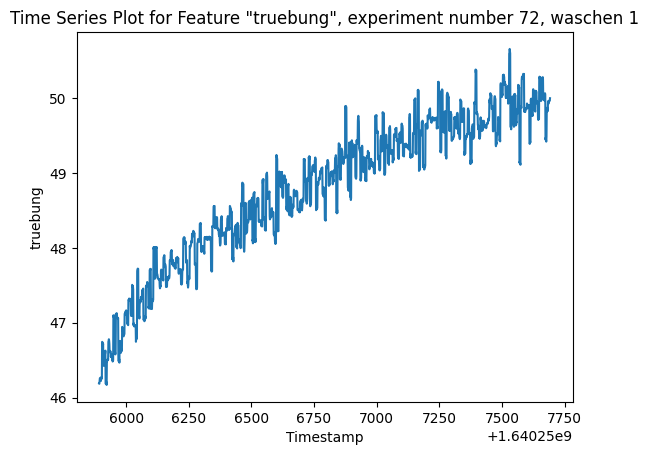

In [306]:
def plot_timeseries(online_df, experiment_number, waschen, y_label):
    tolerance = 1e-3

    experiment_data = online_df[
        (abs(online_df['experimentnummer'] - experiment_number) < tolerance) &
        (abs(online_df['waschen'] - waschen) < tolerance)
    ]

    if not experiment_data.empty:
        plt.figure()
        plt.plot(experiment_data['timestamp'], experiment_data[y_label])
        plt.xlabel('Timestamp')
        plt.ylabel(y_label)
        plt.title('Time Series Plot for Feature "{0}", experiment number {1}, waschen {2}'.format(y_label, experiment_number, waschen))
        plt.show()
    else:
        print("No data found for the specified conditions.")
plot_timeseries(online_df, 72, 1, 'truebung')

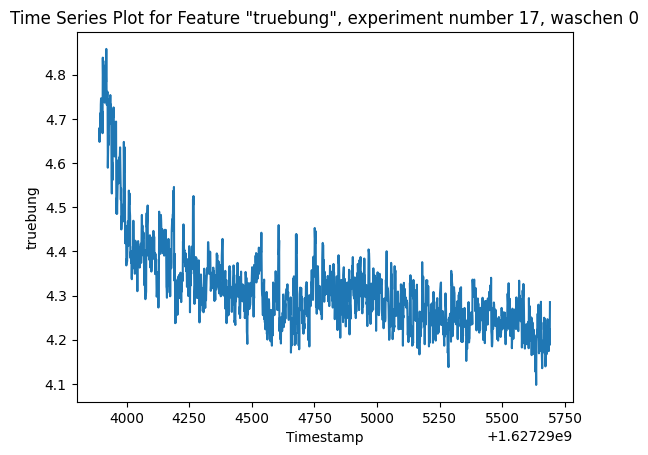

In [307]:
plot_timeseries(online_df, 17, 0, 'truebung')

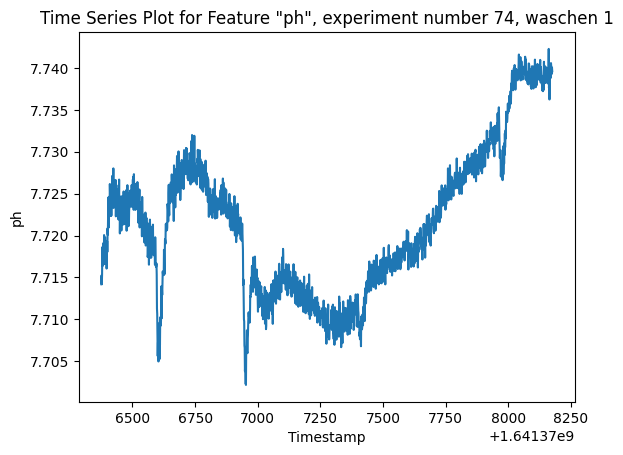

In [308]:
plot_timeseries(online_df, 74, 1, 'ph')

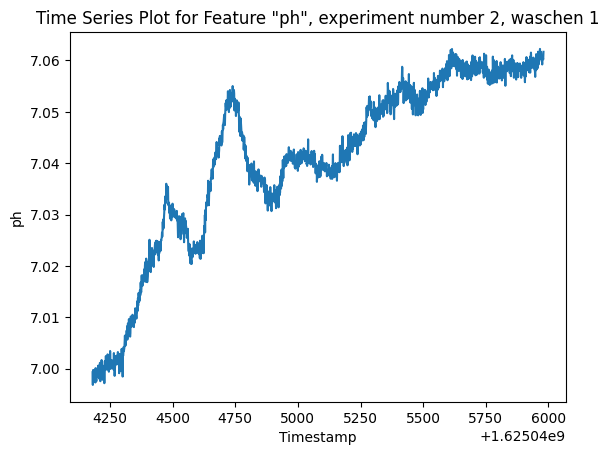

In [309]:
plot_timeseries(online_df, 2, 1, 'ph')

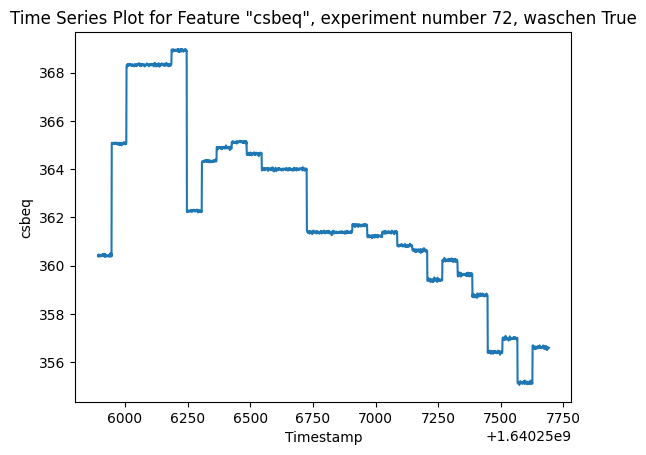

In [310]:
plot_timeseries(online_df, 72, True, 'csbeq')

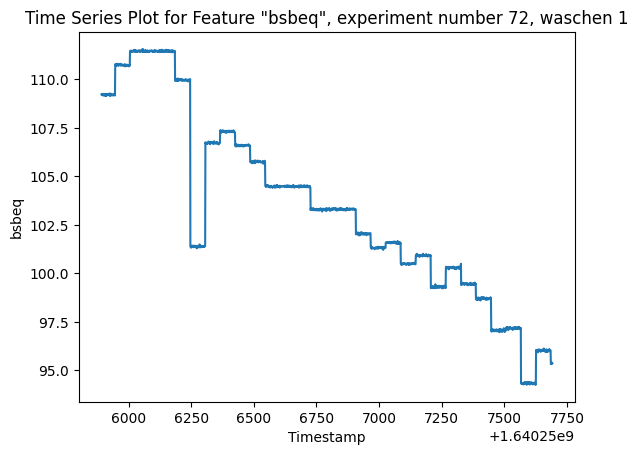

In [311]:
plot_timeseries(online_df, 72, 1, 'bsbeq')

Seems like data is not stable across the timeline. It should make sense to use time series models, but we don't have sufficient data to do so. Otherwise, calculating statistics of each feature and using it as an input to clasical ML model seems reasonable. Although in a longer run with more data, time series models might outperform.

In [312]:
online_df.columns

Index(['experimentnummer', 'timestamp', 'waschen', 'spuelen', 'csbeq',
       'truebung', 'druck1', 'druck2', 'druck3', 'fluss1', 'fluss2', 'ph',
       'leitfaehigkeit', 'alkalinitaet', 'vorschlagsnummer', 'bsbeq', 'abs254',
       'abs360', 'abs210', 'reserv1', 'reserv2'],
      dtype='object')

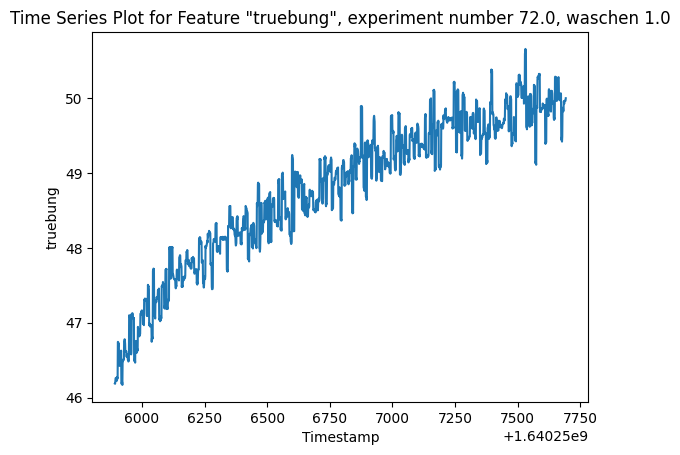

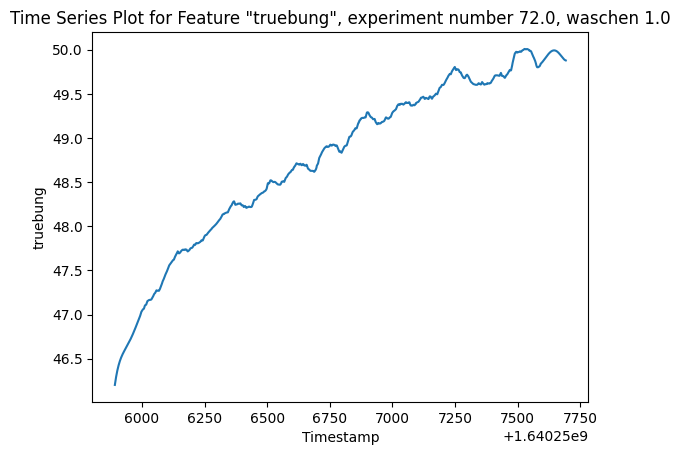

In [313]:
window_length = 200
polyorder = 5

def apply_time_series_filter(data, window_length, polyorder):
    data_sorted = data.sort_values(by="timestamp", ascending=True)
    for col in data.columns:
        if col not in ['experimentnummer', 'waschen', 'timestamp']:
            data_sorted[col] = savgol_filter(data_sorted[col], window_length, polyorder)
    return data_sorted

filtered_df = online_df.groupby(["experimentnummer", "waschen", 'vorschlagsnummer']).apply(
    lambda group: apply_time_series_filter(group, window_length, polyorder)
)
filtered_df = filtered_df.reset_index(drop=True)


plot_timeseries(online_df, 72., 1., 'truebung')
plot_timeseries(filtered_df, 72., 1., 'truebung')

In [314]:
online_df.drop(columns=['timestamp', 'spuelen'], inplace=True)

stat_functions = ['mean', (lambda x:x.std() if not np.isnan(x.std()) else 0), 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]

online_df = online_df.groupby(['experimentnummer', 'waschen', 'vorschlagsnummer']).agg(stat_functions)

online_df.columns = [
    f'{col}_percentile25' if stat == '<lambda_1>' else
    f'{col}_percentile75' if stat == '<lambda_2>' else
    f'{col}_std' if stat == '<lambda_0>' else
    f'{col}_{stat}' for col, stat in online_df.columns]

online_df.reset_index()
online_df

csbeq_mean  csbeq_std  \
experimentnummer waschen vorschlagsnummer                          
1.0              0       0.0                30.519474   0.048190   
                         3.0                88.190182   6.662920   
                 1       0.0                36.111118   6.254667   
                         3.0               299.782790  27.826367   
2.0              0       8.0                36.883188   0.433964   
...                                               ...        ...   
78.0             1       318.0             351.020751   3.677535   
79.0             0       324.0              44.890021   0.406179   
                 1       324.0             351.213623   3.993364   
80.0             0       330.0              64.093953   0.544614   
                 1       330.0             268.365221  10.010462   

                                           csbeq_median  csbeq_percentile25  \
experimentnummer waschen vorschlagsnummer                                     
1.0              0       0.0                  30.520135           30.489801   
                         3.0                  89.164138           88.792996   
                 1       0.0                  30.573665           30.511213   
                         3.0                 304.065392          303.009062   
2.0              0       8.0                  36.928578           36.620334   
...                                                 ...                 ...   
78.0             1       318.0               350.802621          347.554674   
79.0             0       324.0                44.923297           44.561969   
                 1       324.0               350.911465          349.467042   
80.0             0       330.0                63.985363           63.814066   
                 1       330.0               268.982596          266.992611   

                                           csbeq_percentile75  truebung_mean  \
experimentnummer waschen vorschlagsnummer                                      
1.0              0       0.0                        30.552253       6.414123   
                         3.0                        89.594609       8.112615   
                 1       0.0                        41.199833      22.633728   
                         3.0                       305.570483      24.180520   
2.0              0       8.0                        37.216748       5.747559   
...                                                       ...            ...   
78.0             1       318.0                     353.735631     250.038863   
79.0             0       324.0                      45.163290       3.931352   
                 1       324.0                     352.589638      92.604987   
80.0             0       330.0                      64.421633       5.659544   
                 1       330.0                     273.292222      19.710421   

                                           truebung_std  truebung_median  ...  \
experimentnummer waschen vorschlagsnummer                                 ...   
1.0              0       0.0                   0.413080         6.394420  ...   
                         3.0                   0.101597         8.110507  ...   
                 1       0.0                   3.205282        23.789234  ...   
                         3.0                   0.251940        24.197494  ...   
2.0              0       8.0                   0.096233         5.729200  ...   
...                                                 ...              ...  ...   
78.0             1       318.0                 2.097864       250.433382  ...   
79.0             0       324.0                 0.161991         3.891827  ...   
                 1       324.0                 0.383213        92.593135  ...   
80.0             0       330.0                 0.307124         5.612025  ...   
                 1       330.0                 0.428438        19.675392  ...   

                                   

In [315]:
offline_grouped = offline_df.groupby(['experimentnummer', 'bemerkungen']).mean().reset_index()
mapping = {'S1': 0, 'W1': 1}
offline_grouped['waschen'] = offline_grouped['bemerkungen'].map(mapping)
print(offline_grouped.columns)
offline_df = offline_grouped[offline_grouped['bemerkungen'].isin(['S1', 'W1'])]
offline_df = offline_df.drop(columns=['bemerkungen'])


Index(['experimentnummer', 'bemerkungen', 'aktivsauerstoff',
       'anionischetenside', 'bsb', 'carbonathaerte', 'csb', 'leitfaehigkeit',
       'nichtionischentenside', 'oberflaechenspannung', 'peressigsaeure', 'ph',
       'truebung', 'wasserstoffperoxid', 'timestamp_probeentnahme',
       'timestamp_messung', 'vorschlagnummer', 'waschen'],
      dtype='object')


In [316]:
x=0
for i in range(1, 81):
    a = len(offline_df[offline_df['experimentnummer'] == i])
    print(i, a)
    x+=a
print(x)

1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 2
51 2
52 2
53 2
54 2
55 2
56 1
57 2
58 2
59 2
60 2
61 2
62 2
63 2
64 2
65 2
66 2
67 2
68 2
69 2
70 2
71 2
72 2
73 2
74 2
75 2
76 2
77 2
78 2
79 2
80 2
125


In [317]:
print(len(offline_df))
for col in [
    "oberflaechenspannung",
    "anionischetenside",
    "nichtionischentenside",
]:
    offline_df[col] = np.where(
        offline_df[col] < 0, np.nan, offline_df[col]
    )
    print(offline_df[col].count())

125
125
77
107


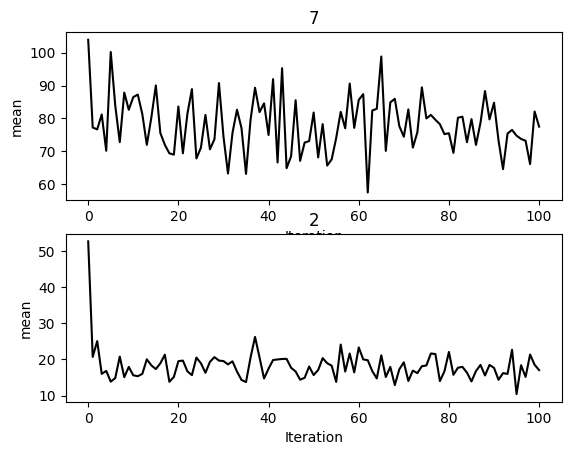

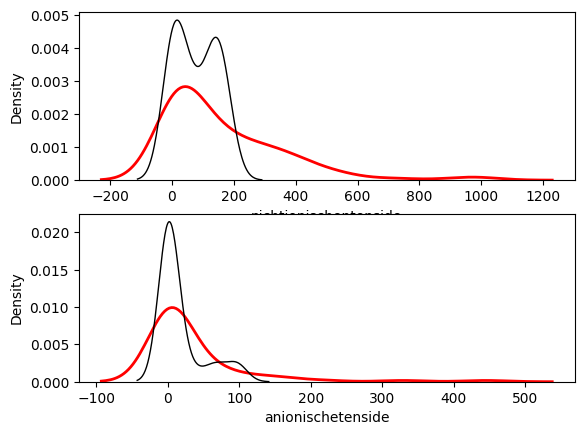

In [318]:
import pandas as pd
import miceforest as mf
kds = mf.ImputationKernel(offline_df, save_all_iterations=True, random_state=42)
kds.mice(100)
kds.plot_mean_convergence()
kds.plot_imputed_distributions()

In [319]:
online_df.reset_index().head(20)

experimentnummer  waschen  vorschlagsnummer   csbeq_mean  csbeq_std  \
0                1.0        0               0.0    30.519474   0.048190   
1                1.0        0               3.0    88.190182   6.662920   
2                1.0        1               0.0    36.111118   6.254667   
3                1.0        1               3.0   299.782790  27.826367   
4                2.0        0               8.0    36.883188   0.433964   
5                2.0        1               8.0   257.444931   1.131618   
6                3.0        0              13.0    53.560584   0.383185   
7                3.0        1              13.0   598.239284  50.596739   
8                4.0        0              21.0    31.356495   0.443051   
9                4.0        1              21.0  1371.880819  14.205980   
10               5.0        0              26.0    30.507157   0.038097   
11               5.0        1              26.0   535.759092  11.002673   
12               6.0        0              30.0    32.181551   0.676890   
13               6.0        1              30.0   510.377092  94.790134   
14               7.0        0              41.0    83.406051   1.506092   
15               7.0        1              41.0   226.831103   4.392410   
16               8.0        0              49.0    30.540133   0.622899   
17               8.0        1              49.0   585.729646  36.018784   
18               9.0        0              59.0    30.510911   0.037044   
19               9.0        1              59.0   579.311785  43.321960   

    csbeq_median  csbeq_percentile25  csbeq_percentile75  ...  reserv1_median  \
0      30.520135           30.489801           30.552253  ...            -0.0   
1      89.164138           88.792996           89.594609  ...            -0.0   
2      30.573665           30.511213           41.199833  ...            -0.0   
3     304.065392          303.009062          305.570483  ...            -0.0   
4      36.928578           36.620334           37.216748  ...            -0.0   
5     257.469146          256.379361          258.298864  ...            -0.0   
6      53.567514           53.332874           53.850331  ...            -0.0   
7     601.675029          598.975760          605.837908  ...            -0.0   
8      31.290076           31.028671           31.730361  ...            -0.0   
9    1373.355373         1372.591217         1374.374246  ...            -0.0   
10     30.507644           30.482664           30.532625  ...            -0.0   
11    534.886995          533.441230          538.468174  ...            -0.0   
12     32.209009           31.700919           32.736280  ...            -0.0   
13    558.684798          484.414599          569.167825  ...            -0.0   
14     83.501545           83.230772           83.787931  ...            -0.0   
15    226.666993          224.474041          227.601987  ...            -0.0   
16     30.525488           30.493370           30.557606  ...            -0.0   
17    592.735457          591.243298          593.660194  ...            -0.0   
18     30.511213           30.486232           30.536194  ...            -0.0   
19    583.339094          582.586100          584.245542  ...            -0.0   

    reserv1_percentile25  reserv1_percentile75  reserv2_mean  reserv2_std  \
0                   -0.0                  -0.0           0.0          0.0   
1                   -0.0                  -0.0           0.0          0.0   
2                   -0.0                  -0.0           0.0          0.0   
3                   -0.0                  -0.0           0.0          0.0   
4                   -0.0                  -0.0           0.0          0.0   
5                   -0.0                  -0.0           0.0          0.0   
6                   -0.0                  -0.0           0.0          0.0   
7                   -0.0                  -0.0           0.0          0.0   
8                   -0.0         

In [320]:
offline_df[['experimentnummer', 'vorschlagnummer']]

experimentnummer  vorschlagnummer
0                   1              1.0
1                   1              1.0
3                   2              3.0
4                   2              3.0
5                   3              5.0
..                ...              ...
123                78            318.0
124                79            324.0
125                79            324.0
126                80            330.0
127                80            330.0

[125 rows x 2 columns]

In [321]:
offline_df = offline_df.loc[:, ['experimentnummer', 'vorschlagnummer', 'waschen', 'oberflaechenspannung', 'anionischetenside', 'nichtionischentenside']]

merged_data = pd.merge(offline_df, online_df, left_on=['experimentnummer', 'waschen'], right_on=['experimentnummer', 'waschen'], how='inner')
merged_data = merged_data.reset_index(drop=True)
merged_data.describe

<bound method NDFrame.describe of     experimentnummer  vorschlagnummer  waschen  oberflaechenspannung  \
0                  1              1.0      0.0                55.700   
1                  1              1.0      0.0                55.700   
2                  1              1.0      1.0                48.325   
3                  1              1.0      1.0                48.325   
4                  2              3.0      0.0                60.950   
..               ...              ...      ...                   ...   
94                78            318.0      1.0                52.300   
95                79            324.0      0.0                70.900   
96                79            324.0      1.0                55.100   
97                80            330.0      0.0                68.700   
98                80            330.0      1.0                48.700   

    anionischetenside  nichtionischentenside  csbeq_mean  csbeq_std  ...  \
0                 NaN    

In [322]:
len(merged_data.experimentnummer.unique())

49

In [323]:
x=0
for i in range(1, 81):
    a = len(merged_data[merged_data['experimentnummer'] == i])
    print(i, a)
    if a > 2:
        print("##")
    x+=a
print(x)

1 4
##
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 2
51 2
52 2
53 2
54 2
55 2
56 1
57 2
58 2
59 2
60 2
61 2
62 2
63 2
64 2
65 2
66 2
67 2
68 2
69 2
70 2
71 2
72 2
73 2
74 2
75 2
76 2
77 2
78 2
79 2
80 2
99


In [324]:
merged_data.describe()

experimentnummer  vorschlagnummer    waschen  oberflaechenspannung  \
count         99.000000        99.000000  99.000000             99.000000   
mean          43.616162       158.837542   0.505051             54.927146   
std           28.510545       115.101863   0.502519             12.158424   
min            1.000000         1.000000   0.000000             35.150000   
25%           12.000000        30.583333   0.000000             43.812500   
50%           55.000000       180.000000   1.000000             55.125000   
75%           68.000000       260.000000   1.000000             66.500000   
max           80.000000       330.000000   1.000000             73.100000   

       anionischetenside  nichtionischentenside   csbeq_mean   csbeq_std  ...  \
count          65.000000              97.000000    99.000000   99.000000  ...   
mean           29.396615             159.478557   233.680949   13.572212  ...   
std            70.410908             197.627409   228.591445   29.270900  ...   
min             0.000000               1.050000    30.475196    0.031071  ...   
25%             0.460000              12.700000    37.857106    0.545434  ...   
50%             1.200000              78.000000   151.302107    2.159600  ...   
75%            14.575000             240.000000   395.586628    6.458794  ...   
max           445.000000            1000.000000  1371.880819  176.964384  ...   

       reserv1_median  reserv1_percentile25  reserv1_percentile75  \
count            99.0                  99.0                  99.0   
mean              0.0                   0.0                   0.0   
std               0.0                   0.0                   0.0   
min              -0.0                  -0.0                  -0.0   
25%              -0.0                  -0.0                  -0.0   
50%              -0.0                  -0.0                  -0.0   
75%              -0.0                  -0.0                  -0.0   
max              -0.0                  -0.0                  -0.0   

       reserv2_mean  reserv2_std  reserv2_median  reserv2_percentile25  \
count          99.0         99.0            99.0                  99.0   
mean            0.0          0.0             0.0                   0.0   
std             0.0          0.0             0.0                   0.0   
min             0.0          0.0            -0.0                  -0.0   
25%             0.0          0.0            -0.0                  -0.0   
50%             0.0          0.0            -0.0                  -0.0   
75%             0.0          0.0            -0.0                  -0.0   
max             0.0          0.0            -0.0                  -0.0   

       reserv2_percentile75  
count                  99.0  
mean                    0.0  
std                     0.0  
min                    -0.0  
25%                    -0.0  
50%                    -0.0  
75%                    -0.0  
max                    -0.0  

[8 rows x 86 columns]

In [325]:
merged_data.columns

Index(['experimentnummer', 'vorschlagnummer', 'waschen',
       'oberflaechenspannung', 'anionischetenside', 'nichtionischentenside',
       'csbeq_mean', 'csbeq_std', 'csbeq_median', 'csbeq_percentile25',
       'csbeq_percentile75', 'truebung_mean', 'truebung_std',
       'truebung_median', 'truebung_percentile25', 'truebung_percentile75',
       'druck1_mean', 'druck1_std', 'druck1_median', 'druck1_percentile25',
       'druck1_percentile75', 'druck2_mean', 'druck2_std', 'druck2_median',
       'druck2_percentile25', 'druck2_percentile75', 'druck3_mean',
       'druck3_std', 'druck3_median', 'druck3_percentile25',
       'druck3_percentile75', 'fluss1_mean', 'fluss1_std', 'fluss1_median',
       'fluss1_percentile25', 'fluss1_percentile75', 'fluss2_mean',
       'fluss2_std', 'fluss2_median', 'fluss2_percentile25',
       'fluss2_percentile75', 'ph_mean', 'ph_std', 'ph_median',
       'ph_percentile25', 'ph_percentile75', 'leitfaehigkeit_mean',
       'leitfaehigkeit_std', 'leitfaeh

In [326]:
df2 = pd.read_csv(r'C:\Users\Illia\Desktop\IMPRESS\Dataset\20220311_114449_impress_backup_designofexperiment.csv', sep=';')

merged_data = pd.merge(df2, merged_data, how='inner', on='vorschlagnummer')

# Save the merged data to Excel
merged_data.to_excel('output_case_2.xlsx', index=False)

c:\Users\Illia\Desktop\IMPRESS\.venv\lib\site-packages\pandas\core\reshape\merge.py:1219: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(


In [327]:
len(merged_data)

79

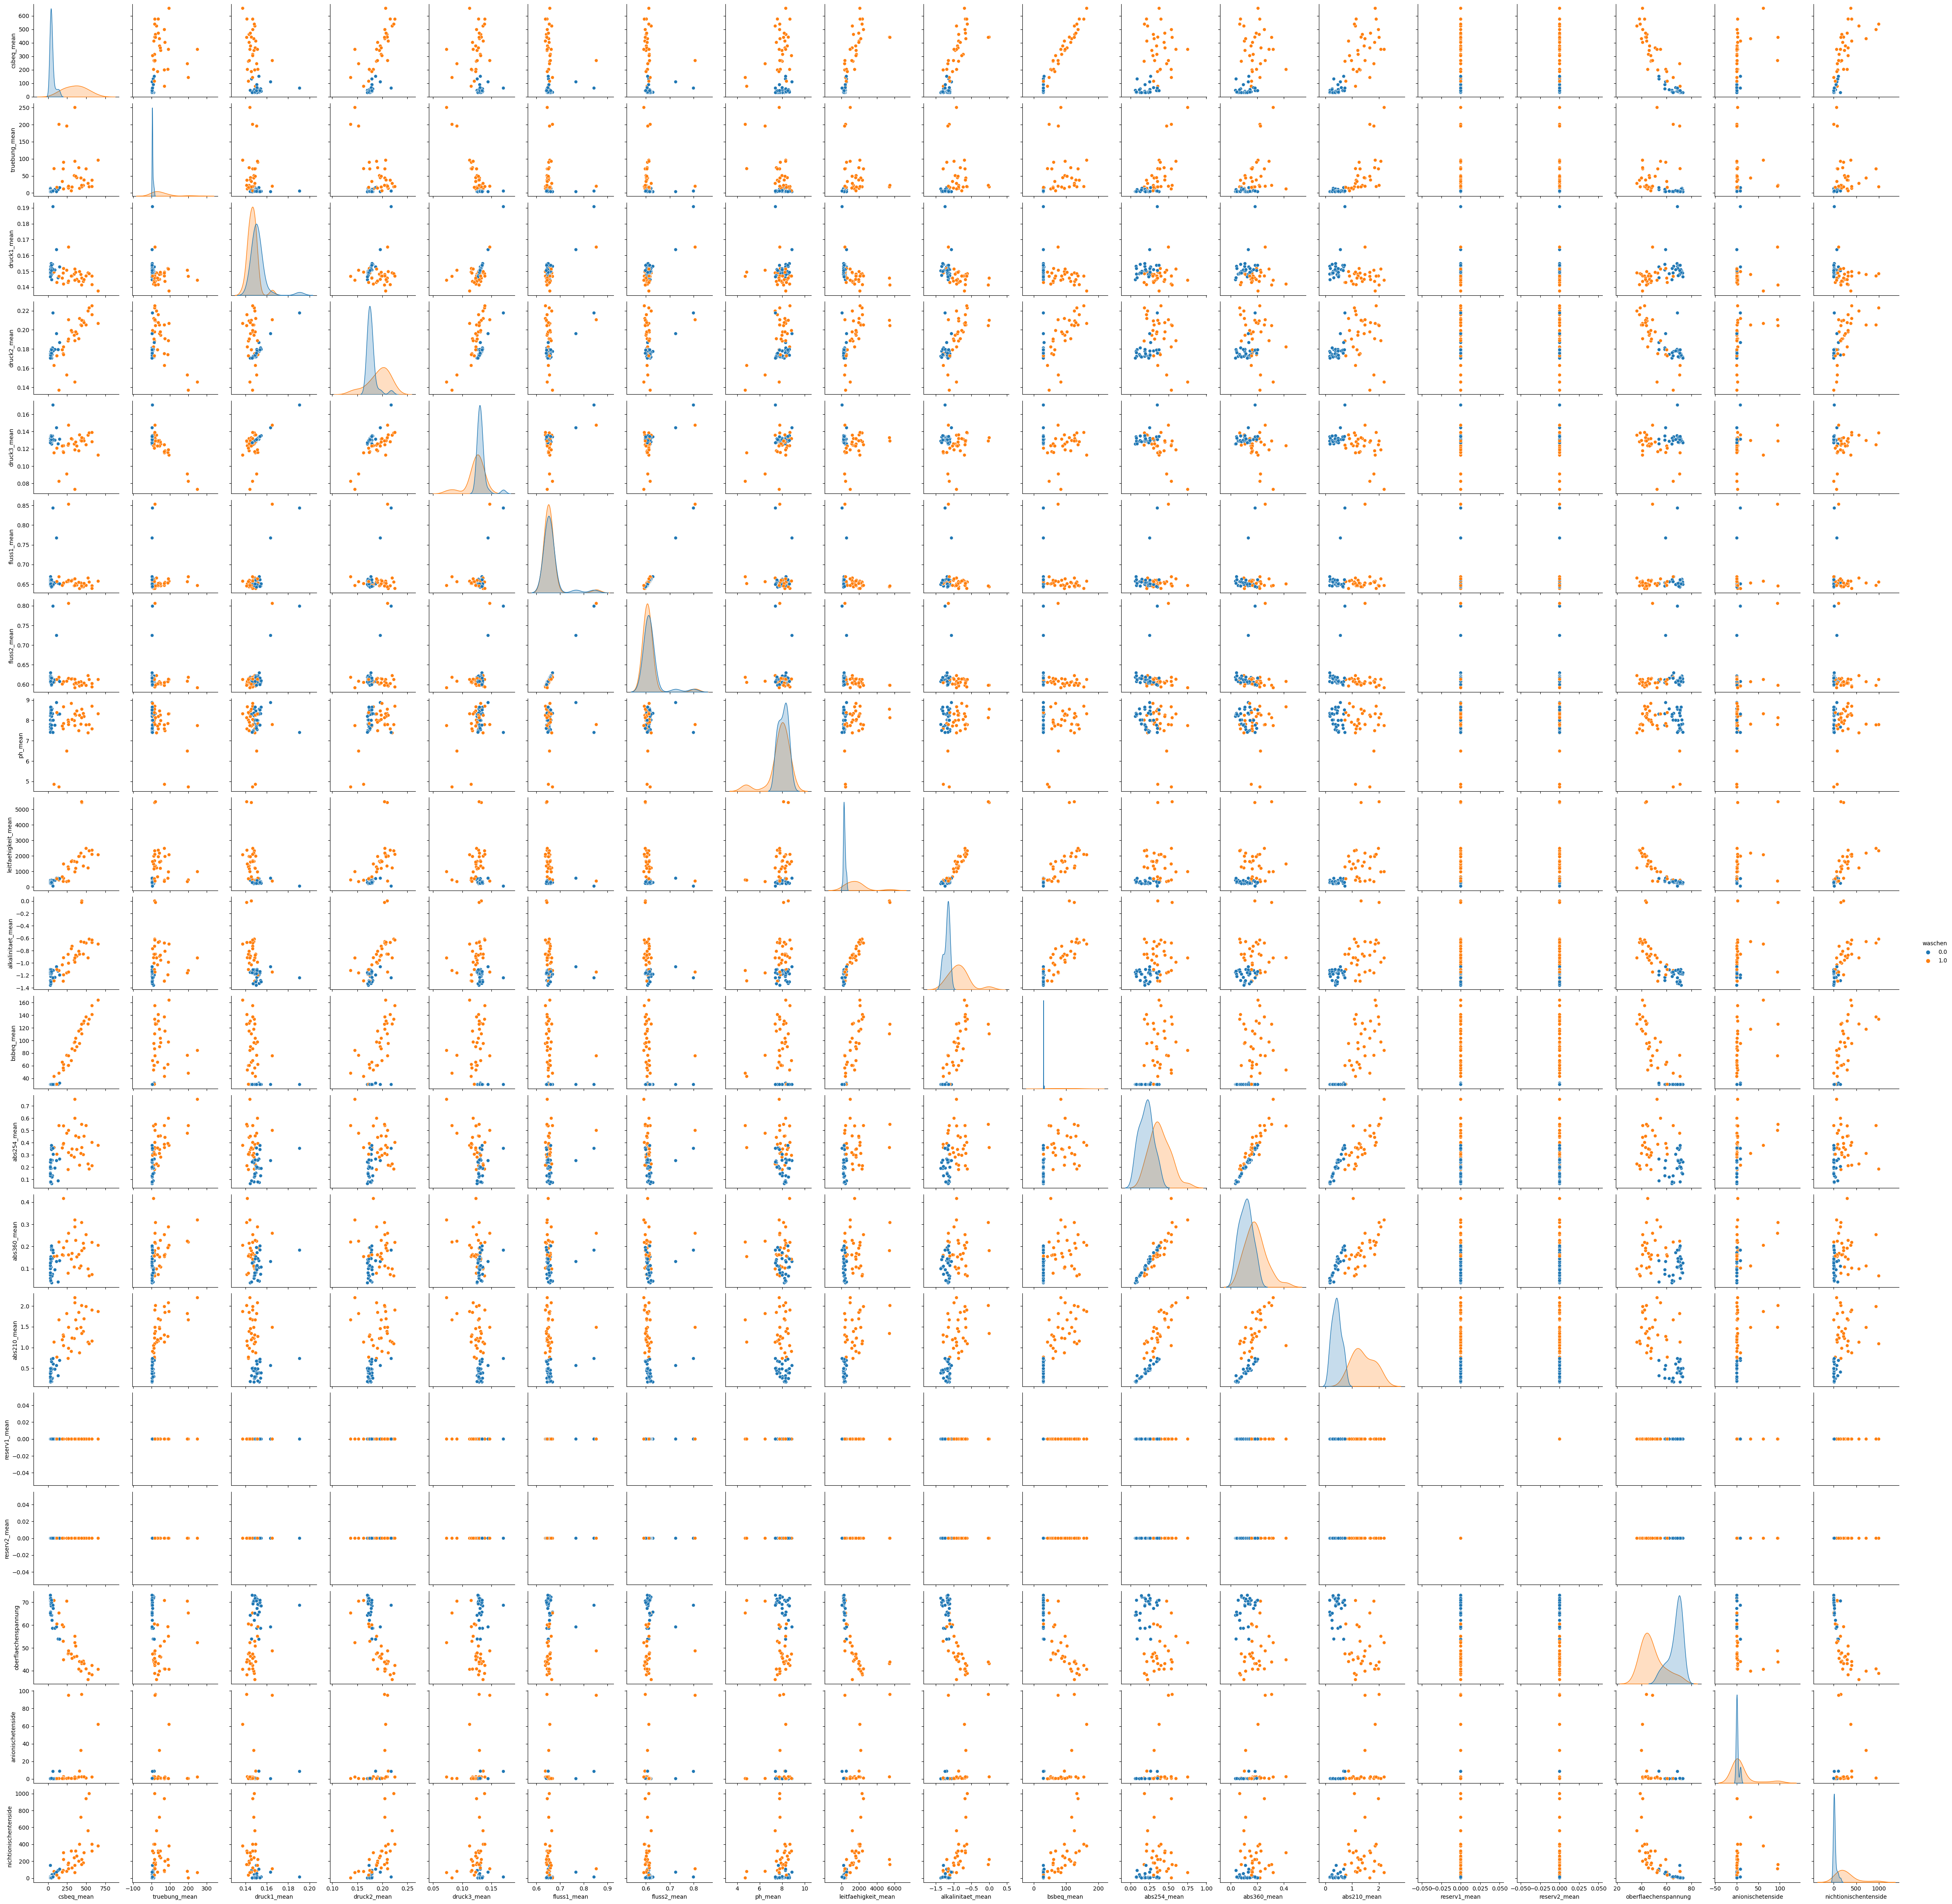

In [280]:
mean_columns = [col for col in merged_data.columns if '_mean' in col] + ['waschen', 'oberflaechenspannung', 'anionischetenside', 'nichtionischentenside']
df_mean_only = merged_data[mean_columns]
sns.pairplot(df_mean_only, hue='waschen')

<AxesSubplot: >

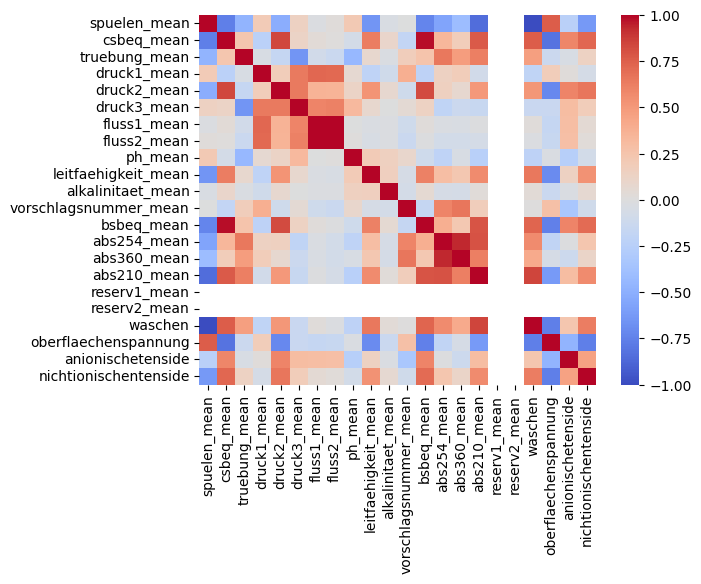

In [ ]:
sns.heatmap(df_mean_only.corr(), cmap='coolwarm')

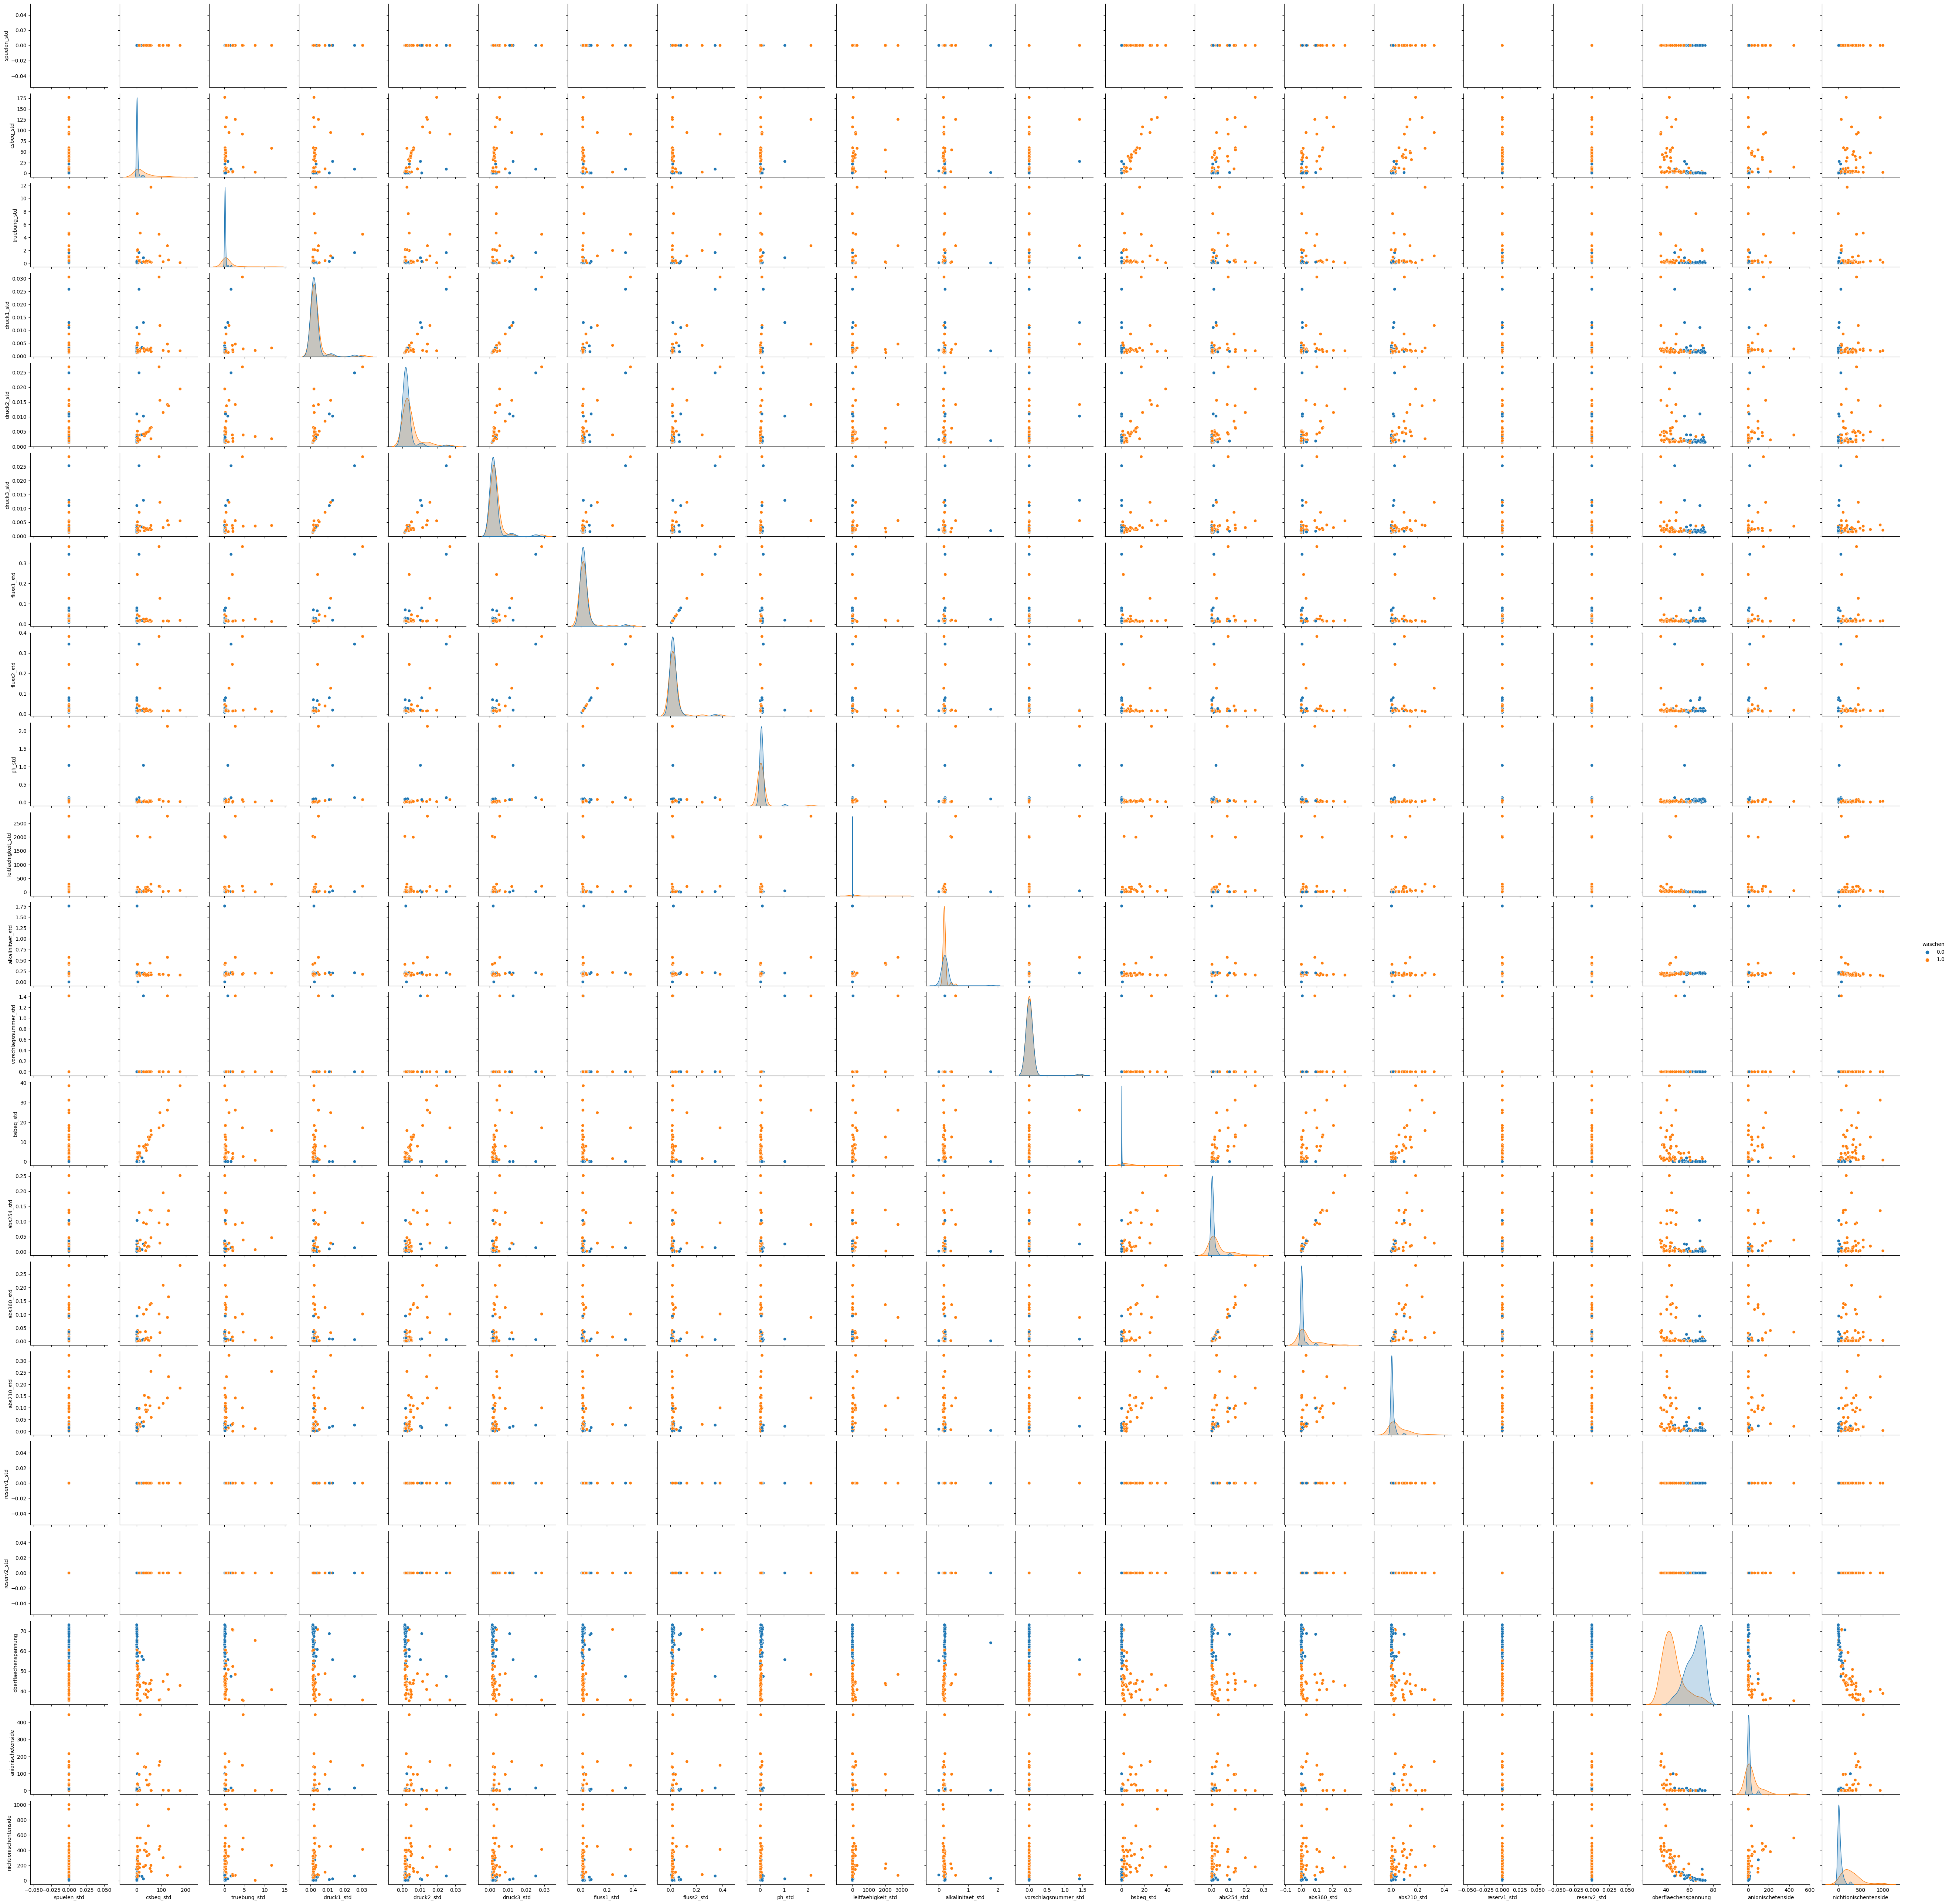

In [ ]:
std_columns = [col for col in merged_data.columns if '_std' in col] + ['waschen', 'oberflaechenspannung', 'anionischetenside', 'nichtionischentenside']
df_std_only = merged_data[std_columns]
sns.pairplot(df_std_only, hue='waschen')

<AxesSubplot: >

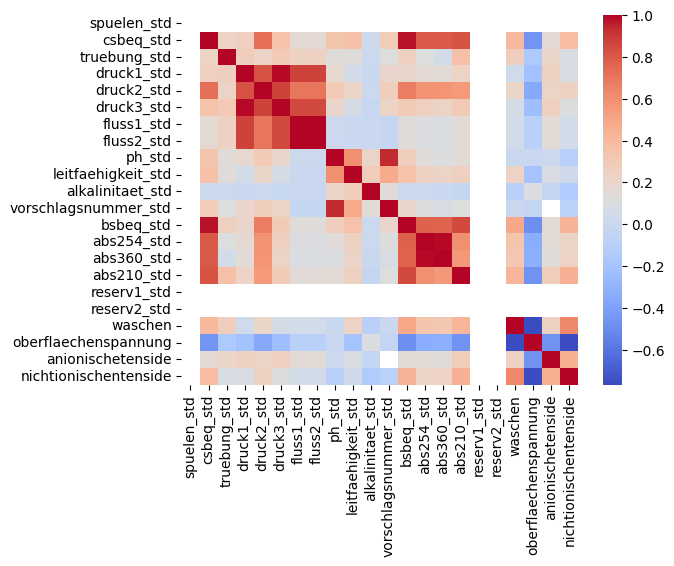

In [ ]:
sns.heatmap(df_std_only.corr(), cmap='coolwarm')

In [ ]:
merged_data

experimentnummer  waschen  oberflaechenspannung  anionischetenside  \
0                  1      0.0                55.700                NaN   
1                  1      1.0                48.325                NaN   
2                  2      0.0                60.950                NaN   
3                  2      1.0                52.325                NaN   
4                  3      0.0                60.775               5.55   
..               ...      ...                   ...                ...   
92                78      1.0                52.300               2.22   
93                79      0.0                70.900                NaN   
94                79      1.0                55.100               0.46   
95                80      0.0                68.700               8.60   
96                80      1.0                48.700              95.00   

    nichtionischentenside  spuelen_mean  spuelen_std  spuelen_median  ...  \
0                   22.00           1.0          0.0             1.0  ...   
1                   69.50           0.0          0.0             0.0  ...   
2                   14.50           1.0          0.0             1.0  ...   
3                   89.50           0.0          0.0             0.0  ...   
4                   44.25           1.0          0.0             1.0  ...   
..                    ...           ...          ...             ...  ...   
92                  65.00           0.0          0.0             0.0  ...   
93                   2.65           1.0          0.0             1.0  ...   
94                 150.00           0.0          0.0             0.0  ...   
95                  13.00           1.0          0.0             1.0  ...   
96                 110.00           0.0          0.0             0.0  ...   

    reserv1_median  reserv1_percentile25  reserv1_percentile75  reserv2_mean  \
0             -0.0                  -0.0                  -0.0           0.0   
1             -0.0                  -0.0                  -0.0           0.0   
2             -0.0                  -0.0                  -0.0           0.0   
3             -0.0                  -0.0                  -0.0           0.0   
4             -0.0                  -0.0                  -0.0           0.0   
..             ...                   ...                   ...           ...   
92            -0.0                  -0.0                  -0.0           0.0   
93            -0.0                  -0.0                  -0.0           0.0   
94            -0.0                  -0.0                  -0.0           0.0   
95            -0.0                  -0.0                  -0.0           0.0   
96            -0.0                  -0.0                  -0.0           0.0   

    reserv2_std  reserv2_median  reserv2_percentile25  reserv2_percentile75  
0           0.0            -0.0                  -0.0                  -0.0  
1           0.0            -0.0                  -0.0                  -0.0  
2           0.0            -0.0                  -0.0                  -0.0  
3           0.0            -0.0                  -0.0                  -0.0  
4           0.0            -0.0                  -0.0                  -0.0  
..          ...             ...                   ...                   ...  
92          0.0            -0.0                  -0.0                  -0.0  
93          0.0            -0.0                  -0.0                  -0.0  
94          0.0            -0.0                  -0.0                  -0.0  
95          0.0            -0.0                  -0.0                  -0.0  
96          0.0            -0.0                  -0.0                  -0.0  

[97 rows x 95 columns]

In [ ]:
targets = ['oberflaechenspannung', 'anionischetenside', 'nichtionischentenside']
features = merged_data.drop(['experimentnummer'] + targets, axis=1)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
stratified_kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

mae_scores = {target: [] for target in targets}

for train_index, test_index in stratified_kfold.split(features, merged_data['waschen']):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = merged_data[targets].iloc[train_index], merged_data[targets].iloc[test_index]

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    for target in targets:
        mae = mean_absolute_error(y_test[target], y_pred[:, targets.index(target)])
        mae_scores[target].append(mae)

for target in targets:
    avg_mae = np.mean(mae_scores[target])
    print(f"Average MAE for '{target}': {avg_mae:.2f}")

ValueError: Input y contains NaN.

In [ ]:
prefixes = ["ph_", "leitfaehigkeit_", "alkalinitaet_"]

selected_features = [col for col in merged_data.columns for prefix in prefixes if col.startswith(prefix)]

features = merged_data[selected_features]
target = merged_data['waschen']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
stratified_kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

log_loss_scores = []
precision_scores = []

for train_index, test_index in stratified_kfold.split(features, target):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    rf_classifier.fit(X_train, y_train)
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]
    print(y_prob)
    print(y_test)
    logloss = log_loss(y_test, y_prob)
    precision = precision_score(y_test, (y_prob > 0.5).astype(int))
    
    log_loss_scores.append(logloss)
    precision_scores.append(precision)

logloss_mean = np.mean(log_loss_scores)
precision_mean = np.mean(precision_scores)
print("Log Loss:", logloss_mean)
print("Precision:", precision_mean)

[0.47 0.24 1.   0.33 0.73 0.55 0.92 0.05 0.   0.97 0.09 0.   1.   0.
 1.   1.   1.   0.   0.05 1.  ]
5     1.0
16    0.0
17    1.0
20    0.0
22    0.0
24    0.0
27    1.0
38    0.0
49    0.0
50    1.0
55    0.0
61    0.0
66    1.0
67    0.0
70    1.0
80    1.0
82    1.0
87    0.0
88    1.0
92    1.0
Name: waschen, dtype: float64
[0.12 0.28 1.   0.99 0.36 0.44 1.   0.13 0.4  1.   1.   1.   0.6  1.
 0.99 0.01 0.08 0.87 0.03 0.99]
12    0.0
14    0.0
19    1.0
25    1.0
30    0.0
32    0.0
33    1.0
36    0.0
40    0.0
43    1.0
45    1.0
54    1.0
57    0.0
58    1.0
74    1.0
77    0.0
81    0.0
86    1.0
91    0.0
94    1.0
Name: waschen, dtype: float64
[0.3  0.19 0.   0.1  0.99 1.   0.99 1.   0.   0.97 1.   0.1  0.03 0.11
 0.4  0.22 0.98 0.   0.3 ]
0     0.0
4     0.0
8     0.0
18    0.0
31    1.0
35    1.0
37    1.0
39    1.0
42    0.0
60    1.0
62    1.0
65    0.0
73    0.0
79    0.0
84    1.0
85    0.0
90    1.0
93    0.0
96    1.0
Name: waschen, dtype: float64
[0.84 0.98 0.04 0.99

In [ ]:
for i in merged_data.experimentnummer.unique():
    print(merged_data[merged_data.experimentnummer==i].waschen)

0    0.0
1    1.0
Name: waschen, dtype: float64
2    0.0
3    1.0
Name: waschen, dtype: float64
4    0.0
5    1.0
Name: waschen, dtype: float64
6    0.0
7    1.0
Name: waschen, dtype: float64
8    0.0
9    1.0
Name: waschen, dtype: float64
10    0.0
11    1.0
Name: waschen, dtype: float64
12    0.0
13    1.0
Name: waschen, dtype: float64
14    0.0
15    1.0
Name: waschen, dtype: float64
16    0.0
17    1.0
Name: waschen, dtype: float64
18    0.0
19    1.0
Name: waschen, dtype: float64
20    0.0
21    1.0
Name: waschen, dtype: float64
22    0.0
23    1.0
Name: waschen, dtype: float64
24    0.0
25    1.0
Name: waschen, dtype: float64
26    0.0
27    1.0
Name: waschen, dtype: float64
28    0.0
29    1.0
Name: waschen, dtype: float64
30    0.0
31    1.0
Name: waschen, dtype: float64
32    0.0
33    1.0
Name: waschen, dtype: float64
34    0.0
35    1.0
Name: waschen, dtype: float64
36    0.0
37    1.0
Name: waschen, dtype: float64
38    0.0
39    1.0
Name: waschen, dtype: float64
40    0.0
